In [190]:
import matplotlib.pyplot as plt 
import os
import numpy as np
from skimage import io, transform
from scipy.spatial.distance import cdist

In [191]:
def load_data(data_path):
    X = []
    y = []
    for filename in os.listdir(data_path):
        img = io.imread(os.path.join(data_path, filename))
        img = transform.rescale(img, 0.25)
        X.append(img)
        filename = filename.split('.')
        y.append(int(filename[0].replace('subject', '')))

    return np.array(X), np.array(y)

In [192]:
X_train, y_train = load_data('./Yale_Face_Database/Training')
X_test, y_test = load_data('./Yale_Face_Database/Testing')

In [193]:
H = X_train.shape[1]
W = X_train.shape[2]

In [194]:
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)

In [195]:
random_idx = np.random.choice(len(X_train), size=10, replace=False)

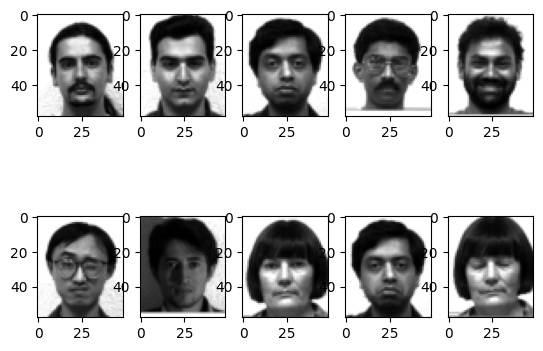

In [196]:
fig, axes = plt.subplots(2, 5)
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[random_idx[idx]].reshape(H, W), cmap='gray')

In [197]:
def PCA(X, output_dim=2):
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    U, S, VT = np.linalg.svd(X_centered, full_matrices=False, compute_uv=True)
    X_projected = U[:, :output_dim] * S[:output_dim]

    return X_projected, VT[:output_dim], X_mean

In [198]:
X_train_projected_pca, X_eigenfaces, X_train_mean = PCA(X_train, output_dim=100)

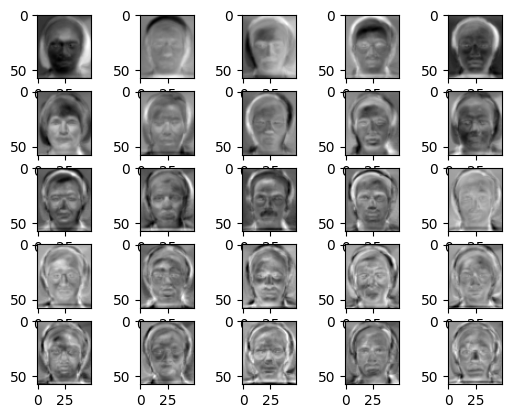

In [199]:
fig, axes = plt.subplots(5, 5)
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(X_eigenfaces[idx].reshape(H, W), cmap='gray')

In [200]:
reconstruction_pca = X_train_projected_pca @ X_eigenfaces + X_train_mean

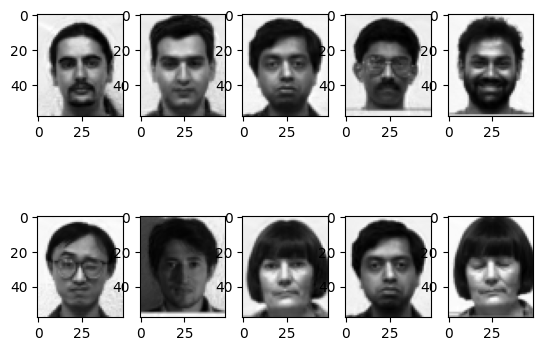

In [201]:
fig, axes = plt.subplots(2, 5)
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(reconstruction_pca[random_idx[idx]].reshape(H, W), cmap='gray')

In [202]:
def LDA(X, y, output_dim=2):
    n_feat = X.shape[1]
    n_class = len(np.unique(y))
    Sw = np.zeros((n_feat, n_feat))
    Sb = np.zeros((n_feat, n_feat))
    X_mean = np.mean(X, axis=0)

    for c in range(n_class):
        mask = (y == c+1)
        mean_c = np.mean(X[mask], axis=0)
        dw = X[mask] - mean_c
        Sw += dw.T @ dw
        db = (mean_c - X_mean).reshape(-1, 1)
        Sb += np.sum(mask) * db @ db.T
    
    A = np.linalg.pinv(Sw) @ Sb
    eigenvalue, eigenvector = np.linalg.eigh(A)
    W = eigenvector[:, ::-1]
    X_projected = X @ W[:, :output_dim]
    
    return X_projected, W[:, :output_dim].T, X_mean

In [203]:
def fisherface(X, y, output_dim=2):
    n_feat = X.shape[1]
    n_class = len(np.unique(y))
    X_projected_pca, W_pca, _ = PCA(X, output_dim=n_feat-n_class)
    X_projected_lda, W_lda, _ = LDA(X_projected_pca, y, output_dim=output_dim)
    W_opt = W_lda @ W_pca

    return X_projected_lda, W_opt

In [204]:
X_train_projected_lda, X_fisherfaces = fisherface(X_train, y_train, output_dim=100)

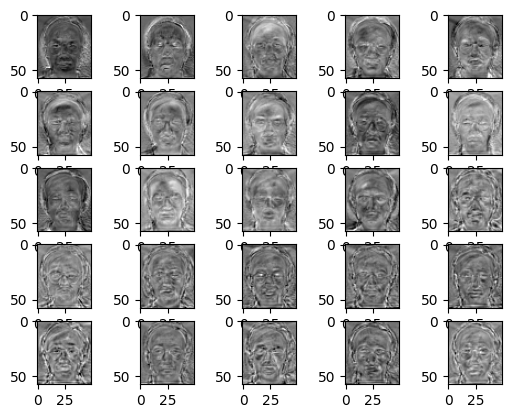

In [205]:
fig, axes = plt.subplots(5, 5)
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(X_fisherfaces[idx].reshape(H, W), cmap='gray')

In [206]:
reconstruction_lda = X_train_projected_lda @ X_fisherfaces + X_train_mean

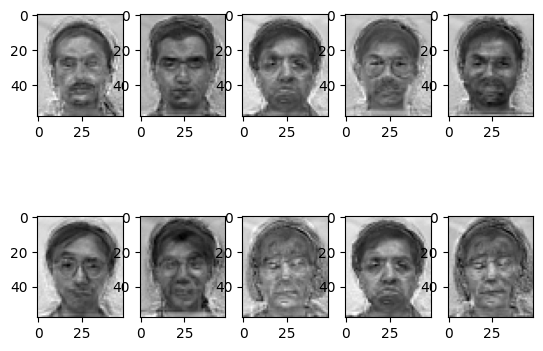

In [207]:
fig, axes = plt.subplots(2, 5)
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(reconstruction_lda[random_idx[idx]].reshape(H, W), cmap='gray')

In [208]:
X_test_mean = np.mean(X_test, axis=0)
X_test_centered = X_test - X_test_mean

In [209]:
X_test_projected_pca = X_test_centered @ X_eigenfaces.T

In [210]:
def KNN(X_test, X_train, y_test, y_train, k=5):
    dist = cdist(X_test, X_train, 'euclidean')
    sorted_index = np.argsort(dist, axis=1)
    k_nearest = sorted_index[:, :k]
    y_pred = np.zeros(len(X_test))

    for i in range(len(X_test)):
        unique, counts = np.unique(y_train[k_nearest[i]], return_counts=True)
        y_pred[i] = unique[np.argmax(counts)]
    
    acc = np.sum(y_pred == y_test) / len(y_test)
    
    return y_pred, acc

In [211]:
y_pred_pca, acc = KNN(X_test_projected_pca, X_train_projected_pca, y_test, y_train, k=5)
print(acc)

0.8666666666666667


In [212]:
X_test_projected_lda = X_test_centered @ X_fisherfaces.T
y_pred_lda, acc = KNN(X_test_projected_lda, X_train_projected_lda, y_test, y_train, k=5)
print(acc)

0.9666666666666667


In [213]:
def polynomial_kernel(X, X_, gamma, coef, degree):
    return np.power(gamma * X @ X_.T + coef, degree)

In [214]:
def RBF_kernel(X, X_, gamma):
    return np.exp(-gamma * cdist(X, X_, 'sqeuclidean'))

In [215]:
# K_train = RBF_kernel(X_train, X_train, gamma=0.01)
# K_test = RBF_kernel(X_test, X_train, gamma=0.01)
K_train = polynomial_kernel(X_train, X_train, gamma=0.01, coef=1, degree=2)
K_test = polynomial_kernel(X_test, X_train, gamma=0.01, coef=1, degree=2)

In [216]:
def kernel_PCA(K, output_dim=2):
    oneN = np.diag(np.full(len(K), 1./len(K)))
    K_centered = K - oneN @ K - K @ oneN + oneN @ K @ oneN
    eigenvalue, eigenvector = np.linalg.eig(K_centered)
    a = eigenvector[:, np.argsort(eigenvalue)[::-1]]
    K_projected = K_centered @ a[:, :output_dim]

    return K_projected, a[:, :output_dim].T, K_centered

In [217]:
K_train_projected, X_kernel_eigenfaces, K_train_centered = kernel_PCA(K_train, output_dim=100)

In [218]:
K_test_projected = K_test @ X_kernel_eigenfaces.T

In [219]:
y_pred_kpca, acc = KNN(K_test_projected, K_train_projected, y_test, y_train, k=5)
print(acc)

0.8333333333333334


## kerenl fisherfaces (method 1)

In [220]:
n_feat = X_train.shape[1]
n_class = len(np.unique(y_test))
K_train_projected, X_kernel_eigenfaces, K_train_centered = kernel_PCA(K_train, output_dim=n_feat-n_class)

In [221]:
K_train_projected_klda, X_kernel_fisherfaces, _ = LDA(K_train_projected, y_train, output_dim=100)
W_opt = X_kernel_fisherfaces @ X_kernel_eigenfaces
K_test_projected_klda = K_test @ W_opt.T
y_pred_klda, acc = KNN(K_test_projected_klda, K_train_projected_klda, y_test, y_train, k=5)
print(acc)

0.8666666666666667


## kernel fisherfaces (method 2)

In [222]:
def OneHotEncode(y):
    n_sample = len(y)
    n_class = len(np.unique(y))
    y_onehot = np.zeros((n_sample, n_class))
    for i in range(n_sample):
        y_onehot[i, y[i]-1] = 1.
    
    return y_onehot

In [223]:
def kernel_LDA(K, y, output_dim=2):
    y_onehot = OneHotEncode(y)
    m_classes = y_onehot.T @ K / np.sum(y_onehot, axis=0)[:, np.newaxis]
    indices = y - 1
    N = K @ (K - m_classes[indices])
    # N += np.eye(len(K)) * 1e-8
    m_classes_centered = m_classes - np.mean(K, axis=1)
    M = m_classes_centered.T @ m_classes_centered
    A = np.linalg.pinv(N) @ M
    eigenvalue, eigenvector = np.linalg.eigh(A)
    a = eigenvector[:, ::-1]
    K_projected = K @ a[:, :output_dim]

    return K_projected, a[:, :output_dim].T

In [224]:
def kernel_fisherfaces(K, y, output_dim):
    n_feat = len(K)
    n_class = len(np.unique(y))
    K_projected_kpca, W_kpca, K_centered = kernel_PCA(K, output_dim=n_feat)
    K_projected_klda, W_klda = kernel_LDA(K_projected_kpca, y, output_dim=output_dim)
    W_opt = W_klda @ W_kpca
    
    return K_projected_klda, W_opt

In [225]:
K_train_projected, W_opt = kernel_fisherfaces(K_train, y_train, output_dim=100)
K_test_projected = K_test @ W_opt.T
y_pred_klda, acc = KNN(K_test_projected, K_train_projected, y_test, y_train, k=5)
print(acc)

0.8333333333333334
